In [1]:
# Usman Jameel - 170295877

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.utils.data as data
import torchvision.transforms as transforms
from torch.nn import functional as F
import random
import torchvision
import my_utils as mu
import matplotlib.pyplot as plt
from IPython import display


In [3]:
train_iter, test_iter = mu.load_data_fashion_mnist(batch_size=64) #loading the fashion-mnist dataset

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [4]:
class Model(nn.Module):
    
    def __init__(self):
        super().__init__()

        #the stem linear layer
        self.stem = nn.Sequential( 
             nn.Linear(
                in_features= 196,
                out_features= 256
            ),
        )
        
        #the first MLP 
        self.multiLayerPerceptron1 = nn.Sequential(   
            nn.Linear(256,1024), 

            
            nn.ReLU(),  #non-linear activation function
            nn.LeakyReLU(0.1), 
            nn.Linear(1024, 512) 
        )
        

        #the second MLP
        self.multiLayerPerceptron2 = nn.Sequential( 
            nn.Linear(512, 1024), 

            nn.ReLU(), #non-linear activation function
            nn.LeakyReLU(0.1),
            nn.Linear(1024, 512), 
        )


        self.classifier = nn.Sequential( #classifier
            nn.Linear(
                in_features=512, 
                out_features=10
            ),
        )
        


    def stem_function(self, x):
        features_matrix_list = []
 
        for i in range(x.shape[0]): #iterating for each image 
            image = x[i].numpy() 
            image = np.squeeze(image, 0)  

            #dividing the image into patches
            patches = np.array([image[i:i+14, j:j+14] for j in range(0,28,14) for i in range(0,28,14)])
            patches_tensor = torch.from_numpy(patches) 

            #vectorsing each patch
            patches_tensor = patches_tensor.view(patches_tensor.shape[0], -1) 
            
            features_matrix = self.stem(patches_tensor) 

            # Appending to the list
            features_matrix_list.append(features_matrix.detach().numpy())

        features_matrix_array = np.array(features_matrix_list)
        features_matrix_tensor = torch.from_numpy(features_matrix_array)
      
        return features_matrix_tensor

        

    def forward(self, x):
        
        # the stem
        x = self.stem_function(x)
        
        #the backbone
        x = torch.transpose(x,0,1)
        x = self.multiLayerPerceptron1(x)
        x = torch.transpose(x,0,1)
        x = self.multiLayerPerceptron2(x)
        
        #the classifer
        x = torch.mean(x,1) #computing the mean feature vector
        x = self.classifier(x)

        output = F.log_softmax(x, dim=1)
        return output

In [5]:
# calling the model
model = Model()

In [6]:
#the loss function
loss = nn.CrossEntropyLoss()

In [7]:
#the optimizer function
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9) 

In [8]:
def accuracy(y_hat, y):  #y_hat is a matrix; 2nd dimension stores prediction scores for each class.
    """Compute the number of correct predictions."""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1) # Predicted class is the index of max score         
    cmp = (y_hat.type(y.dtype) == y)  # because`==` is sensitive to data types
    return float(torch.sum(cmp)) # Taking the sum yields the number of correct predictions.

# Example: only 1 sample is correctly classified.
y = torch.tensor([0, 2])
y_hat = torch.tensor([[0.1, 0.3, 0.6], [0.3, 0.2, 0.5]])
accuracy(y_hat, y) / len(y)

0.5

In [9]:
class Accumulator:  
    """For accumulating sums over `n` variables."""
    def __init__(self, n):
        self.data = [0.0] * n # [0, 0, ..., 0]
    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]
    def reset(self):
        self.data = [0.0] * len(self.data)
    def __getitem__(self, idx):
        return self.data[idx]

In [10]:
def evaluate_accuracy(net, data_iter): 
    """Compute the accuracy for a model on a dataset."""
    metric = Accumulator(2)  # No. of correct predictions, no. of predictions
    for _, (X, y) in enumerate(data_iter):
        metric.add(accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

In [11]:
#evaluates the accuracy before the training
evaluate_accuracy(model, test_iter)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


0.1

In [12]:
def train_epoch_ch3(net, train_iter, loss, optimizer, batch_size=256, num_outputs=10):  
    """The training function for one epoch."""
    # Set the model to training mode
    if isinstance(net, torch.nn.Module):
        net.train()
    # Sum of training loss, sum of training accuracy, no. of examples
    metric = Accumulator(3)
    for X, y in train_iter:
        # Compute gradients and update parameters
        y_hat = net(X)
        l = loss(y_hat, y)
        optimizer.zero_grad()
        l.backward()
        optimizer.step()
        metric.add(float(l) * len(y), accuracy(y_hat, y), y.size().numel())
    # Return training loss and training accuracy
    return metric[0] / metric[2], metric[1] / metric[2]

In [13]:
class Animator:  
    """For plotting data in animation."""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        # Incrementally plot multiple lines
        if legend is None:
            legend = []
        mu.use_svg_display()
        self.fig, self.axes = mu.plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # Use a lambda function to capture arguments
        self.config_axes = lambda: mu.set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # Add multiple data points into the figure
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

In [14]:
def train_ch3(net, train_iter, test_iter, loss, num_epochs, optimizer):
    test_accuracy_array=[]
    """Train a model."""
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.0, 1.0],
                        legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):
        train_metrics = train_epoch_ch3(net, train_iter, loss, optimizer)
        test_acc = evaluate_accuracy(net, test_iter)
        test_accuracy_array.append("epoch: " + str(epoch) + " test_acc: " + str(test_acc))
        animator.add(epoch + 1, train_metrics + (test_acc,))
    train_loss, train_acc = train_metrics
    print(test_accuracy_array)

['epoch: 0 test_acc: 0.7028', 'epoch: 1 test_acc: 0.8065', 'epoch: 2 test_acc: 0.8222', 'epoch: 3 test_acc: 0.8404', 'epoch: 4 test_acc: 0.8332', 'epoch: 5 test_acc: 0.8565', 'epoch: 6 test_acc: 0.8378', 'epoch: 7 test_acc: 0.8485', 'epoch: 8 test_acc: 0.8604', 'epoch: 9 test_acc: 0.8614', 'epoch: 10 test_acc: 0.8595', 'epoch: 11 test_acc: 0.8604', 'epoch: 12 test_acc: 0.8618', 'epoch: 13 test_acc: 0.8747', 'epoch: 14 test_acc: 0.8749', 'epoch: 15 test_acc: 0.8713', 'epoch: 16 test_acc: 0.8688', 'epoch: 17 test_acc: 0.8736', 'epoch: 18 test_acc: 0.8756', 'epoch: 19 test_acc: 0.8724', 'epoch: 20 test_acc: 0.8744', 'epoch: 21 test_acc: 0.8814', 'epoch: 22 test_acc: 0.8713', 'epoch: 23 test_acc: 0.879', 'epoch: 24 test_acc: 0.8703', 'epoch: 25 test_acc: 0.8787', 'epoch: 26 test_acc: 0.883', 'epoch: 27 test_acc: 0.8715', 'epoch: 28 test_acc: 0.8868', 'epoch: 29 test_acc: 0.8809']


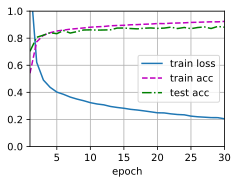

In [15]:
num_epochs = 30 #the number of epochs i.e. iterations
train_ch3(model, train_iter, test_iter, loss, num_epochs, optimizer)